# Working with MRI data in Python
In this tutorial we will discuss how to interact with *Nifti* files &mdash; the file format used most in the MRI community &mdash; using the Python package *Nibabel*. 

**What you'll learn**:  ... 

* you know how to load, manipulate, and analyze Nifti-files



## What is "nifti"?
Usually, every scanner manufacturer (Philips, Siemens, GE, etc.) have their own proprietary data format. To streamline the development and use of neuroimaging software packages, the Neuroimaging InFormatics Technology Initiative came up with a new, standardized format, *nifti*, that most neuroimaging packages should support. As such, usually the first step in any (f)MRI preprocessing pipeline is to convert the scanner-specific files (e.g., PAR/RECs) to nifti. 
In this tutorial you'll work with these nifti-files (also called nifti images), which you can recognize by their extension of *.nii* or its compressed version *.nii.gz*. This file-format is supported by most neuroimaging software packages. 

However, we'd like to inspect and analyze nifti images in Python as well! *Nibabel* is an awesome Python package that allows us to read and load nifti images, and convert them to numpy arrays in a straightforward manner.

In [ ]:
# Let's load some other packages we need
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib # common way of importing nibabel

In [ ]:
#@title Data retrieval
import os, requests

fname = "data.zip"
url = "https://osf.io/9du7h/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
!unzip data.zip

We'll load in an example anatomical MRI scan (`anat.nii.gz`) from the current directory using nibabel below:

The anatomical and resting-state fMRI scan we provide here was collected as part of the Natural Scenes Dataset (NSD) collection. 

Credits: https://www.nature.com/articles/s41593-021-00962-x

In [ ]:
mri_file = 'data/anat.nii.gz'
img = nib.load(mri_file)

Note the type of `img`: the `Nifti1Image` class. This is a custom class just like a Numpy array, with its own attributes and methods!

In [ ]:
print(type(img))

For example, one attribute of `Nifti1Image` objects is the `shape` (which is similar to the numpy array attribute with the same name):

In [ ]:
print(img.shape)

Here, the `shape` attribute is telling us that this is a 3D (anatomical) scan and has 91 voxels in the first dimension, 109 voxels in the second dimension, and 91 voxels in the third dimension.

## The three parts of nifti images
Nifti images can be roughly divided into three "parts":
1. The header with metadata;
2. The image data;
3. The affine matrix

All three parts are of course represented in nibabel's `Nifti1Image` class. Let's go through the first two parts. We'll skip the third part since it is more advanced

### The header
The header of nifti files contain metadata about the scan, such as the units of measurement, the voxel size, etc. In `Nifti1Images`, the header is an attribute:

In [ ]:
# here, we're storing the header attribute in a new variable, hdr, for easy of use
hdr = img.header

Perhaps confusingly, the header is a custom object (a `Nifti1Header` object) as well, with its own methods and attributes. For example, it has a method called `get_zooms()`, which returns the voxel size (and optionally the sampling rate, if it's a fMRI file):

In [ ]:
hdr.get_zooms()  # it's a 2x2x2 mm MRI file!

Let's also load in a functional MRI file to see the difference with an anatomical MRI file:

In [ ]:
fmri_file = 'data/restingfmri.nii.gz'
f_img = nib.load(fmri_file)
print(f_img.shape)
print(f_img.header.get_zooms())

In case of fMRI files, the fourth dimension (almost) always represents the "time" dimension. So you can assume that a nifti image of an fMRI file has 4 dimensions, with the first three being the spatial dimensions (similar to the anatomical MRI file: $X \times Y \times Z$) and the last (fourth) being the time dimension ($T$).

So for the above file, you can assume that it has 125 timepoints and has a sampling rate of 1.33 seconds (i.e., a new volume was scanned every 1.33 seconds).

Moreover, you can infer that this file contains data from $81 \times 104 \times 83$ voxels with dimensions $1.8 \times 1.8 \times 1.8$ (in millimeters). To be honest, in practice, you won't deal a lot with the header (as you are generally aware of the dimensions/units of your data), so let's look at the *actual* data!

### The data
When we loaded in the data and created a `Nifti1Image` object, we actually didn't load in the *actual* data (i.e., voxel intensities) in memory yet! This is postponed because it's quite a memory-intensive operation

Anyway, to actually load in the data, you can call the `get_fdata()` method, which will return a numpy array with the same dimensions as the image data. We'll take a look at the anatomical MRI data (`anat.nii.gz`):

In [ ]:
img_data = img.get_fdata()
print(type(img_data))  # it's a numpy array!
print(img_data.shape)

Okay, so `img_data` is a 3D numpy array with ... what exactly? Let's check it out:

In [ ]:
print(img_data)

It's just a bunch of numbers! This is important to remember: **like any image (like your standard png, jpeg, or gif), MRI scans are also just (3D or 4D) arrays of numbers**! The higher the number, the more signal the scanner recorded at that voxel. (It's actually a little more complex than this, but that's beyond the scope of this course!) 

Often, the absolute value of the signal intensities is not necessarily most or only important thing. The *relative differences* between different voxels in space or within voxels across time is also important. For example, for anatomical scans, apart from a high overall signal intensity, you often want a good *contrast* between white and gray matter (i.e., different signal intensities between voxels in these two tissue types). For functional MRI, apart from a clear tissue contrast and a high overall signal intensity, you often also want little (non-experimentally related) differences in signal intensity within a voxel across time.

Anyway, when we printed this 3D array (of $91 \times 109 \times 91$), the notebook chose not to display all 902629 numbers but instead truncated it. The reason it only printed zeros is because the first and last couple of numbers in each dimension likely doesn't contain any (signal related to) brain, just empty space!

So, let's index a small $3 \times 3 \times 3$ patch of voxels in roughly the middle of the brain to check what values these voxels contain:

In [ ]:
img_data.size

In [ ]:
n = 91//2
mid_vox = img_data[n-1:n+2, n-1:n+2, n-1:n+2]
print(mid_vox.shape)
print(mid_vox)

That's better! The exact values are not necessarily directly interpretable, i.e., you cannot say that the value 61978.46 is good (or bad), because the exact *scale* of the signal intensities (whether it goes from 0-100 or from 0-100,000) depends on the specific scanner hardware and specific nifti conversion software.

Like any image, (f)MRI scans can be visualized by plotting the numbers and assigning colors to the numbers. Often we visualize brain images in brain and white, with higher signal intensities being brighter and lower signal intensities being darker. Importantly, remember that our data here cannot directly be plotted as a (2D) image, because our data (an anatomical scan) is 3D! However, we *can* just plot a single *slice* of the 3D volume, for example, the middle slice of our first voxel axis:

In [ ]:
mid_slice_x = img_data[91//2,:,:]
print(mid_slice_x.shape)

We can use matplotlib to plot this slice as an image using the `imshow` function you're seen before:

In [ ]:
# Note that the transpose the slice (using the .T attribute).
# This is because imshow plots the first dimension on the y-axis and the
# second on the x-axis, but we'd like to plot the first on the x-axis and the
# second on the y-axis. Also, the origin to "lower", as the data was saved in
# "cartesian" coordinates.
plt.imshow(mid_slice_x.T, cmap='gray', origin='lower')
plt.xlabel('First axis')
plt.ylabel('Second axis')
plt.colorbar(label='Signal intensity')
plt.show()

Depending on which dimension you you slice along, you can see different views of the brain

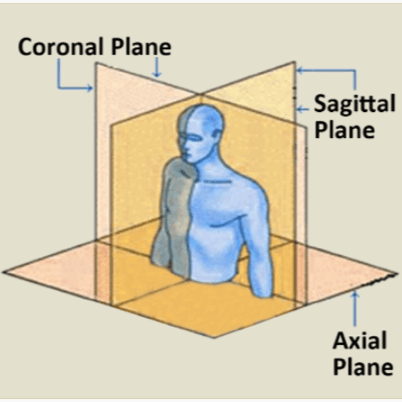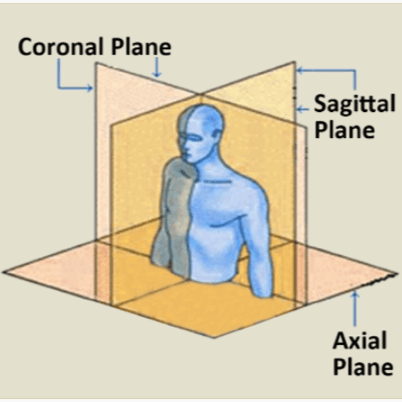


So far, we have only looked at *structural* (3D) MRI data. This course is mainly about analyzing *functional* data, so let's look at the data from an fMRI scan. We'll use the `Nifti1Image` object `func_img` from before. We'll load the memory with the `get_fdata` method. 

In [ ]:
f_img_data = f_img.get_fdata()
print(f_img_data.shape)

Now, you can think about this 4D array as a series of 3D arrays (volumes), in which the fourth dimension represents time (as shown in the image below).
<br><br>

![img](https://nilearn.github.io/stable/_images/niimgs.jpg)

*Source: [nilearn website](https://nilearn.github.io/stable/_images/niimgs.jpg)*

These separate 3D arrays (from the first three dimensions) in fMRI files are often called "volumes" or "dynamics". So, for example, the first volume refers to the first 3D array that was recorded.

Just like the anatomical MRI data, the values in the fMRI data just represent numbers:

In [ ]:
# printing a small 3x3x3 volume of voxels from the first timepoint
print(f_img_data[38:41, 38:41, 20:23, 0])

Again, we can visualize these numbers as images, at least for the first three dimensions, as these represent the spatial dimensions (the fourth dimension represents time). For example, we can visualize a single slice (e.g., $x = 39$) of the first volume ($t = 0$) as follows:

In [ ]:
mid_slice_x_fmri = f_img_data[39, :, :, 0]  # x = 39, t = 0
print("Shape of slice: %s" % (mid_slice_x_fmri.shape,))

plt.imshow(mid_slice_x_fmri.T, cmap='gray', origin='lower')
plt.xlabel('First axis')
plt.ylabel('Second axis')
plt.colorbar(label='Signal intensity')
plt.show()

However, we can also look at fMRI data from a different perspective, that is, from the time dimension! For example, we could extract a single voxel's *time series* (i.e., how the signal intensity varies across time) and plot the signal intensity values of that voxel across time. First, let's extract the time series of one particular voxel (e.g., the middle one across all spatial dimensions):

In [ ]:
mid_vox_ts = f_img_data[39, 39, 21, :]  # note the ":", saying: give me ALL the timepoints
print("Voxel timeseries shape: %s" % (mid_vox_ts.shape,))

What we effectively did in the previous cell is to extract the signal intensity at the *same* spatial coordinates ($x=39, y=39, z=21$) across all 125 timepoints. We show this visually in the next cell, where the show the coordinates as a red box across 20 timepoints (not all 125, because that would clutter the notebook too much):

In [ ]:
from matplotlib import patches

fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(20, 10))  # 20 timepoints
# Loop over the first 20 volumes/timepoints
for t, ax in enumerate(axes.flatten()):    
    ax.imshow(f_img_data[39, :, :, t].T, cmap='gray', origin='lower')  # index with t!
    rect = patches.Rectangle((38, 20), 2, 2, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.axis('off')
    ax.set_title('t = %i' % t, fontsize=20)
fig.tight_layout()

Note that it is *really* hard to spot whether the image of the slice is actually different between different time points! To the naked eye, it just seems like the same image. This is because activity fluctations (over time) in fMRI are **very** small - most of the time just 1-3% compared to baseline (average) activity. That's why it's hard to spot activity differences by looking at the pictures alone (without any scaling).

It's actually easier to see these time-by-time fluctuations in signal intensity by plotting the time series directly:

In [ ]:
plt.figure(figsize=(18, 3))
plt.plot(mid_vox_ts, 'o-', ms=4)
plt.xlim(-1, mid_vox_ts.size)
plt.ylabel('Signal intensity', fontsize=15)
plt.xlabel('Time (nr. of volumes)', fontsize=15)
plt.show()

## Attributions
Parts adapted from https://lukas-snoek.com/NI-edu/fMRI-introduction/week_1/python_for_mri.html